In [1]:
%matplotlib inline
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import imageio
from pylab import imshow, show
import scipy
import numpy as np
import raw_process3 as raw_process

In [2]:
raw = raw_process.read("sample2.ARW")

In [3]:
color_matrix = [1141, -205, 88, -52, 1229, -154, 70, -225, 1179]
raw_array = raw_process.get_raw_array(raw)
blc_raw = raw_process.black_level_correction(raw, raw_array)
wb_raw = raw_process.white_balance_Bayer(raw, blc_raw)
dms_input = wb_raw

In [4]:
hlpf = np.array([[1, 2, 3, 4, 3, 2, 1]]) / 16

In [5]:
vlpf = np.transpose(hlpf)

In [6]:
hhpf = np.array([[-1, 2, -3, 4, -3, 2, -1]]) / 16
vhpf = np.transpose(hhpf)

In [7]:
identity_filter = np.zeros((7, 7))
identity_filter[3, 3] = 1

In [8]:
FC1 = np.matmul(vhpf, hhpf)

In [9]:
FC2H = np.matmul(vlpf, hhpf)
FC2V = np.matmul(vhpf, hlpf)

In [10]:
FL = identity_filter - FC1 - FC2V - FC2H

In [11]:
# f_C1 at 4 corners
c1_mod = scipy.signal.convolve2d(dms_input, FC1, boundary='symm', mode='same')

In [12]:
# f_C1^1 at wy = 0, wx = +Pi/-Pi
c2h_mod = scipy.signal.convolve2d(dms_input, FC2H, boundary='symm', mode='same')
# f_C1^1 at wy = +Pi/-Pi, wx = 0
c2v_mod = scipy.signal.convolve2d(dms_input, FC2V, boundary='symm', mode='same')

In [13]:
# f_L at center
f_L = scipy.signal.convolve2d(dms_input, FL, boundary='symm', mode='same')

In [14]:
# Move c1 to the center by shifting by Pi in both x and y direction
# f_c1 = c1 * (-1)^x * (-1)^y
f_c1 = c1_mod.copy()
f_c1[:, 1::2] *= -1
f_c1[1::2, :] *= -1

In [15]:
# Move c2a to the center by shifting by Pi in x direction, same for c2b in y direction
c2v = c2v_mod.copy()
c2v[1::2, :] *= -1
c2h = c2h_mod.copy()
c2h[:, 1::2] *= -1
# f_c2 = (c2v_mod * x_mod + c2h_mod * y_mod) / 2
f_c2 = (c2v + c2h) / 2

In [16]:
# generate RGB channel using 
# [R, G, B] = [[1, 1, 2], [1, -1, 0], [1, 1, - 2]] x [L, C1, C2]
height, width = dms_input.shape
dms_img = np.zeros((height, width, 3))
dms_img[:,:,0] = f_L + f_c1 + 2 * f_c2
dms_img[:,:,1] = f_L - f_c1
dms_img[:,:,2] = f_L + f_c1 - 2 * f_c2

In [17]:
img_ccm = raw_process.color_correction_matrix(dms_img, color_matrix)
rgb_image = raw_process.gamma_correction(img_ccm)

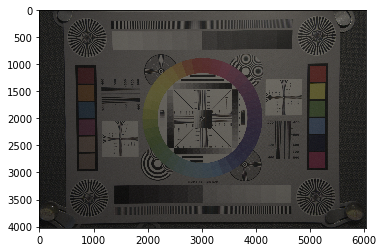

In [18]:
outimg = rgb_image.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)

In [19]:
raw_process.write(rgb_image, "advanced_demosaic.png")